# Project Proposal

## Idea: Sentiment analysis of Corona Virus Tweets compared against it's spread, by state

Propose a project that uses a large, publicly accessible dataset. Explain your motivation for tackling this problem, discuss the data source(s) you are using, and explain the analysis you are performing. At a minimum, you will need to do enough exploratory data analysis to convince someone that the project is viable and generate two interesting non-trivial plots or other assets supporting this. Explain the plots and give url links to them.

#### Justification:
Since the outbreak of the COVID-19 pandemic, numerous problems have arisen due to the spreading of fake news and misinformation. These problems are changing peoples behaviours and costing lives. I propose a look into how shared information about COVID-19 is shared and how this affects peoples' attitudes and behaviours, and consequently the spread of the virus.

I have conducted an investigatory analysis using time series data on the confirmed cases of coronavirus in the US, provided by the John Hopkins University. I have paired this with a Naive Bayes sentiment analysis of data from Official US Government Twitter account (state-level). 

Twitter is a rich and up-to-date source of information that comes directly from the public. Twitter is also used by many official bodies to help share important information. It is therefore ideal for getting an impression of how information is shared and the effects this has on peoples' attitudes towards COVID-19.

#### Data sources:
* Confirmed Data: https://github.com/CSSEGISandData/COVID-19
* Death Data: https://github.com/CSSEGISandData/COVID-19
* Tweet Data: https://developer.twitter.com/en

### Installs and imports

In [1]:
def run_installs():
    !pip install nltk
    !pip install pandas
    !pip install seaborn
    !pip install tweepy
    
# Uncomment next line to install required libraries
# run_installs()

In [90]:
import asyncio
import collections
import datetime
import math
import os
import random
import re
import string
import sys
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import tweepy

from nltk import classify
from nltk import FreqDist
from nltk import NaiveBayesClassifier
from nltk.corpus import stopwords
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

In [91]:
sns.set()

## Virus Data

In [3]:
if not os.path.exists('data'):
    os.makedirs('data')

In [4]:
confirmed_df = pd.read_csv('data/time_series_covid19_US.csv', low_memory=False)  # 1.6 MB

In [5]:
confirmed_df.head(5)

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20
0,16,AS,ASM,16,60.0,NaN,American Samoa,US,-14.2710,-170.1320,...,0,0,0,0,0,0,0,0,0,0
1,316,GU,GUM,316,66.0,NaN,Guam,US,13.4443,144.7937,...,186,188,192,200,222,222,222,225,226,231
2,580,MP,MNP,580,69.0,NaN,Northern Mariana Islands,US,15.0979,145.6739,...,30,30,30,30,30,30,30,30,30,30
3,630,PR,PRI,630,72.0,NaN,Puerto Rico,US,18.2208,-66.5901,...,5951,6003,6111,6195,6463,6525,6564,6685,6820,6877
4,850,VI,VIR,850,78.0,NaN,Virgin Islands,US,18.3358,-64.8963,...,72,73,73,73,73,76,76,76,76,80


### Limit data to just the 48 US mainland states 

This should minimize the affects of cultural differences or any other confounding factors.

In [6]:
states = set(confirmed_df['Province_State'])
excluded_regions = ['Grand Princess',
                    'Alaska',
                    'Northern Mariana Islands',
                    'Puerto Rico',
                    'Guam',
                    'Hawaii',
                    'American Samoa',
                    'District of Columbia',
                    'Virgin Islands',
                    'Diamond Princess']

def exclude_regions(regions):
    return [True if r not in excluded_regions else False for r in regions]

In [7]:
states_codes = {'AL': 'Alabama', 'AR': 'Arkansas', 'AZ': 'Arizona', 'CA': 'California',
                'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida',
                'GA': 'Georgia', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana',
                'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts',
                'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota',
                'MO': 'Missouri', 'MS': 'Mississippi', 'MT': 'Montana', 'NC': 'North Carolina',
                'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
                'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma',
                'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia',
                'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming'}
len(states_codes)

48

In [8]:
US_mainland_df = confirmed_df[exclude_regions(confirmed_df['Province_State'])]
mainland_states = sorted(set(US_mainland_df['Province_State']))
print(len(mainland_states))
US_mainland_df.head(10)

48


,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,...,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20
5,84001001,US,USA,840,1001.0,Autauga,Alabama,US,32.539527,-86.644082,...,367,369,394,405,425,428,436,447,463,473
6,84001003,US,USA,840,1003.0,Baldwin,Alabama,US,30.727750,-87.722071,...,374,377,386,398,405,415,422,435,449,462
7,84001005,US,USA,840,1005.0,Barbour,Alabama,US,31.868263,-85.387129,...,244,250,262,265,271,271,276,279,287,303
8,84001007,US,USA,840,1007.0,Bibb,Alabama,US,32.996421,-87.125115,...,113,115,118,123,123,124,126,132,138,146
9,84001009,US,USA,840,1009.0,Blount,Alabama,US,33.982109,-86.567906,...,119,121,127,136,140,146,150,156,165,173
10,84001011,US,USA,840,1011.0,Bullock,Alabama,US,32.100305,-85.712655,...,308,311,318,318,324,324,325,325,332,347
11,84001013,US,USA,840,1013.0,Butler,Alabama,US,31.753001,-86.680575,...,548,551,563,567,570,574,576,579,582,586
12,84001015,US,USA,840,1015.0,Calhoun,Alabama,US,33.774837,-85.826304,...,198,200,202,202,203,205,207,208,212,225
13,84001017,US,USA,840,1017.0,Chambers,Alabama,US,32.913601,-85.390727,...,471,472,487,493,502,507,514,520,529,535
14,84001019,US,USA,840,1019.0,Cherokee,Alabama,US,34.178060,-85.606390,...,51,51,53,56,56,56,56,56,56,62


In [9]:
start_date = '4/1/20'  # Start from 1st April 2020
sum_by_state = {state: US_mainland_df[US_mainland_df['Province_State'] == state].sum(axis = 0, skipna = True) for state in mainland_states}
US_df = pd.DataFrame(sum_by_state).loc[start_date:]
US_df

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Idaho,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
4/1/20,1060,1413,584,9399,3342,3557,368,6956,4638,566,...,129,2933,4355,888,321,1483,5608,191,1556,130
4/2/20,1233,1596,643,10773,3728,3824,393,9008,5348,776,...,165,3013,5069,1086,338,1706,6389,216,1748,150
4/3/20,1495,1769,704,12004,4173,4914,450,10268,5831,891,...,187,3067,5734,1248,389,2012,6846,237,2012,162
4/4/20,1614,2019,743,12837,4565,5276,593,11537,6160,1022,...,212,3322,6567,1428,461,2407,7247,282,2030,187
4/5/20,1765,2269,837,15034,4950,5675,673,12350,6647,1078,...,240,3633,7209,1601,512,2640,7825,324,2320,197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6/21/20,30021,52591,15561,178546,30524,45755,10775,97291,64701,4006,...,6297,35102,112944,17462,1159,57994,28680,2533,24819,1197
6/22/20,30454,54599,16083,184765,30689,45782,10820,100217,65928,4256,...,6326,35553,117790,17906,1163,58465,28870,2552,25068,1230
6/23/20,31097,58378,16678,191477,30877,45899,10847,103503,67810,4254,...,6353,36303,122932,18300,1164,58994,29386,2593,25331,1254
6/24/20,32064,60190,17375,195925,31139,45913,10889,109014,69381,4402,...,6419,37235,128132,18784,1184,59514,29869,2631,25763,1282


### Engineer Feature: Increase from prevous day 

In [10]:
increase_df = pd.DataFrame({row1[0]: row1[1] - row0[1] for row1, row0 in zip(US_df[1:].iterrows(), US_df[:-2].iterrows())}).T
increase_df

,Alabama,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,Georgia,Idaho,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
4/2/20,173,183,59,1374,386,267,25,2052,710,210,...,36,80,714,198,17,223,781,25,192,20
4/3/20,262,173,61,1231,445,1090,57,1260,483,115,...,22,54,665,162,51,306,457,21,264,12
4/4/20,119,250,39,833,392,362,143,1269,329,131,...,25,255,833,180,72,395,401,45,18,25
4/5/20,151,250,94,2197,385,399,80,813,487,56,...,28,311,642,173,51,233,578,42,290,10
4/6/20,187,191,38,985,233,1231,110,974,667,23,...,48,169,834,77,31,238,486,21,129,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6/20/20,547,3217,511,4351,161,158,70,4049,1800,133,...,67,429,4187,643,3,650,624,32,385,6
6/21/20,472,2464,419,3333,191,40,94,3494,892,2,...,72,656,3363,394,12,551,455,33,280,18
6/22/20,433,2008,522,6219,165,27,45,2926,1227,250,...,29,451,4846,444,4,471,190,19,249,33
6/23/20,643,3779,595,6712,188,117,27,3286,1882,-2,...,27,750,5142,394,1,529,516,41,263,24


## Twitter Data

My Twitter credentials have been redacted from this notebook. However, a csv file containing all the information that was used has been included in its stead.

### Import data from csv

In [20]:
# all_gov_tweets_df = pd.read_csv(f"data/gov_tweets_final.csv")

#### Authorization

In [11]:
credentials = dict(pd.read_csv('data/twitter_credentials.csv', low_memory=False))
key = credentials['TWITTER_KEY'][0]
secret_key = credentials['TWITTER_SECRET_KEY'][0]
access_token = credentials['TWITTER_ACCESS_TOKEN'][0]
access_token_secret = credentials['TWITTER_ACCESS_TOKEN_SECRET'][0]

In [12]:
auth = tweepy.OAuthHandler(key, secret_key)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Search API

In [13]:
columns=['query', 'user', 'text', 'date', 'location', 'link']

def get_tweets(query, n=10, lang='en'):
    tweets = []
    for tweet in api.search(q=query, count=n, lang=lang):
        data = {columns[0]: query,
                columns[1]: tweet.user.name,
                columns[2]: tweet.text,
                columns[3]: tweet.created_at,
                columns[4]: tweet.user.location,
                columns[5]: f"https://twitter.com/{tweet.user.id}/status/{tweet.id}"}
        tweets.append(data)
    return tweets

In [14]:
queries = ['corona', 'virus', 'washing hands', 'doctor', 'hospital', 'government']
max_tweets = 100
tweet_df = pd.DataFrame(get_tweets(queries[0], max_tweets))
for query in queries[1:]:
    tweets = get_tweets(query, max_tweets)
    tweet_df = tweet_df.append(tweets)
tweet_df

,query,user,text,date,location,link
0,corona,रोहित कुमार आर्य,RT @Abhi_Rohila: Stock tips...!! @nto1927 \n\n...,2020-06-27 09:07:50,,https://twitter.com/1261276323479240705/status...
1,corona,Otto,PSA - Wash Your Hands Corona,2020-06-27 09:07:50,WHRW's Scenic Basement Studio,https://twitter.com/390267106/status/127680441...
2,corona,#FindingGaurav ©,@PTI_News A. Rahul may enlighten India with a ...,2020-06-27 09:07:49,Mewar,https://twitter.com/1500975553/status/12768044...
3,corona,Vivek Singh,RT @PTHAKUR2907: It's fine that you unlock ess...,2020-06-27 09:07:49,,https://twitter.com/844613159944163330/status/...
4,corona,Liaquat Hussain chheena,RT @MoeedNj: Corona tu bahana hi hay! This lov...,2020-06-27 09:07:49,"Karachi, Pakistan",https://twitter.com/769914478867677184/status/...
...,...,...,...,...,...,...
95,government,peter mcdonnell,"@natalieben Don't like to be negative, but hop...",2020-06-27 09:07:42,,https://twitter.com/865207844177620994/status/...
96,government,Chandra Kumar,RT @BloodDonorsIn: #Bengaluru \nNeed #Blood Ty...,2020-06-27 09:07:42,"Hyderabad, Telangana",https://twitter.com/144342974/status/127680438...
97,government,Sarita Varon,RT @KirbySommers: Jeffrey Epstein was responsi...,2020-06-27 09:07:42,"Sydney, New South Wales",https://twitter.com/1252192679091306496/status...
98,government,MyKidsMom,RT @kksheld: Texas hospital CEO: COVID inpatie...,2020-06-27 09:07:42,United States,https://twitter.com/929549587/status/127680438...


Unfortunately, the Twitter search API is limited to the past 7 days. If we want to go beyond that, we will have to either pay for the Premium API or use a user_timeline. I will go for the latter option.

#### User TImeline

As this alternative method only allows for the tweets of specific users to be searched for, I have decided to use state officals as they regularly release updates and presumably have at least some influence over the people in their state. 

Only verified accounts were included and not all states had verified government accounts.

In [15]:
states_codes = {'AL': 'Alabama', 'AR': 'Arkansas', 'AZ': 'Arizona', 'CA': 'California',
                'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida',
                'GA': 'Georgia', 'IA': 'Iowa', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana',
                'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'MA': 'Massachusetts',
                'MD': 'Maryland', 'ME': 'Maine', 'MI': 'Michigan', 'MN': 'Minnesota',
                'MO': 'Missouri', 'MS': 'Mississippi', 'MT': 'Montana', 'NC': 'North Carolina',
                'ND': 'North Dakota', 'NE': 'Nebraska', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
                'NM': 'New Mexico', 'NV': 'Nevada', 'NY': 'New York', 'OH': 'Ohio', 'OK': 'Oklahoma',
                'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 
                'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VA': 'Virginia',
                'VT': 'Vermont', 'WA': 'Washington', 'WI': 'Wisconsin', 'WV': 'West Virginia', 'WY': 'Wyoming'}
len(states_codes)

48

In [191]:
target_users = {'CAgovernor': 'California',
                'delaware_gov': 'Delaware',
                'georgiagov': 'Georgia',
                'IN_gov': 'Indiana',
                'ksgovernment': 'Kansas',
                'StateMaryland': 'Maryland',
                'CarsonCityGov': 'Nevada',
                'NYGov': 'New York',
                'rigov': 'Rhode Island',
                'texasgov': 'Texas',
                'UtahGov': 'Utah',
                'WAStateGov': 'Washington'}
user_tweets = []

In [17]:
def get_user_timeline_tweets(user, n=10):
    print(user)
    for status in tweepy.Cursor(api.user_timeline, screen_name=user, tweet_mode="extended").items(n):
        tweet = status._json
        data = {columns[1]: tweet['user']['screen_name'],
                columns[2]: tweet['full_text'],
                columns[3]: tweet['created_at'],
                columns[4]: tweet['user']['location'],
                columns[5]: f"https://twitter.com/{tweet['user']['id']}/status/{tweet['id']}"}
        user_tweets.append(data)

In [18]:
num_tweets = 2500
for t_user in target_users:
    get_user_timeline_tweets(t_user, n=num_tweets)

CAgovernor
delaware_gov
georgiagov
IN_gov
ksgovernment
StateMaryland
CarsonCityGov
NYGov


Rate limit reached. Sleeping for: 452


rigov
texasgov
UtahGov
WAStateGov


In [19]:
all_gov_tweets_df = pd.DataFrame(user_tweets)
all_gov_tweets_df.to_csv(f"data/gov_tweets_{num_tweets}.csv", sep=',', index=False)

### Exclude tweets before 1st April 2020

In [22]:
pd.to_datetime(all_gov_tweets_df['date'])

0       2020-06-27 01:52:15+00:00
1       2020-06-27 00:15:13+00:00
2       2020-06-26 23:48:27+00:00
3       2020-06-26 23:00:28+00:00
4       2020-06-26 22:17:42+00:00
                   ...           
28937   2013-01-16 19:26:51+00:00
28938   2013-01-16 19:22:19+00:00
28939   2013-01-16 17:18:13+00:00
28940   2013-01-15 23:43:33+00:00
28941   2013-01-15 19:39:52+00:00
Name: date, Length: 28942, dtype: datetime64[ns, UTC]

In [23]:
start_datetime = pd.to_datetime(start_date)
gov_tweets_df = all_gov_tweets_df[pd.to_datetime(all_gov_tweets_df['date']) >= start_datetime.tz_localize('UCT')]

In [24]:
gov_tweets_df

,user,text,date,location,link
0,CAgovernor,RT @CAStateParks: A friendly reminder - if you...,Sat Jun 27 01:52:15 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276694803...
1,CAgovernor,"Today, Governor @GavinNewsom visited Tri Tool,...",Sat Jun 27 00:15:13 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276670384...
2,CAgovernor,"""This victory, won by a coalition of states le...",Fri Jun 26 23:48:27 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276663646...
3,CAgovernor,California is now the first place in the world...,Fri Jun 26 23:00:28 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276651572...
4,CAgovernor,RT @MyCalVet: Californians must wear face cove...,Fri Jun 26 22:17:42 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276640807...
...,...,...,...,...,...
26940,WAStateGov,.@PSETalk is offering bill assistance to their...,Tue Apr 14 23:54:23 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12502108...
26941,WAStateGov,RT @GovInslee: These are challenging times. Bu...,Tue Apr 14 23:49:52 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12502096...
26942,WAStateGov,RT @GovInslee: The West Coast is ahead of the ...,Tue Apr 14 16:48:31 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12501036...
26943,WAStateGov,"RT @GovInslee: Washington, you have responded ...",Thu Apr 09 19:13:00 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12483280...


### Check counts of each user

In [25]:
user_counts = {}
for t_user in target_users:
    user_counts[t_user] = len(gov_tweets_df[gov_tweets_df['user'] == t_user])
user_counts

{'CAgovernor': 975,
 'delaware_gov': 281,
 'georgiagov': 64,
 'IN_gov': 0,
 'ksgovernment': 30,
 'StateMaryland': 65,
 'CarsonCityGov': 54,
 'NYGov': 609,
 'rigov': 39,
 'texasgov': 348,
 'UtahGov': 1866,
 'WAStateGov': 20}

## Sentiment Analyzer

In [26]:
def run_downloads():
    nltk.download('twitter_samples')
    nltk.download('punkt')
    nltk.download('wordnet')
    nltk.download('averaged_perceptron_tagger')
    nltk.download('stopwords')
    
# run_downloads()
    
stop_words = stopwords.words('english')

In [27]:
def tokenize(tweet_tokens):
    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        token = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|"\
                       "(?:%[0-9a-fA-F][0-9a-fA-F]))+", '', token)
        token = re.sub("(@[A-Za-z0-9_]+)", '', token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

def remove_noise(tweet_tokens):
    all_cleaned_tokens = []
    for tweet_tokens in tweet_tokens:
        all_cleaned_tokens.append(tokenize(tweet_tokens))
    return all_cleaned_tokens

def get_all_words(cleaned_tokens):
    for tokens in cleaned_tokens:
        for token in tokens:
            yield token
            
def get_dataset_from_tokens(cleaned_tokens, tag):
    dataset = []
    for tweet_tokens in cleaned_tokens:
        bag_of_tokens = {token: True for token in tweet_tokens}
        dataset.append((bag_of_tokens, tag))
    return dataset

In [28]:
# Get training data
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Get tokenized training data
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

In [29]:
# Remove noise (normalize + stop word removal)
positive_cleaned_tokens = remove_noise(positive_tweet_tokens)
negative_cleaned_tokens = remove_noise(negative_tweet_tokens)

In [30]:
# Word frequency distributions
positive_freq_dist = FreqDist(get_all_words(positive_cleaned_tokens))
negative_freq_dist = FreqDist(get_all_words(negative_cleaned_tokens))
print(positive_freq_dist.most_common(10))
print(negative_freq_dist.most_common(10))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]
[(':(', 4585), (':-(', 501), ("i'm", 343), ('...', 332), ('get', 325), ('miss', 291), ('go', 275), ('please', 275), ('want', 246), ('like', 218)]


In [31]:
# Convert data to NLTK-required format
positive_dataset = get_dataset_from_tokens(positive_cleaned_tokens, "Positive")
negative_dataset = get_dataset_from_tokens(negative_cleaned_tokens, "Negative")
dataset = positive_dataset + negative_dataset

In [32]:
# Split data
split_ratio = 0.7
split = int(len(dataset) * split_ratio)
random.shuffle(dataset)
train_data = dataset[slice(0, split)]
test_data = dataset[slice(split, len(dataset))]

In [33]:
# Build model
classifier = NaiveBayesClassifier.train(train_data)
print(f"Accuracy is: {classify.accuracy(classifier, test_data)}")
print(classifier.show_most_informative_features(10))

Accuracy is: 0.9973333333333333
Most Informative Features
                      :) = True           Positi : Negati =    995.7 : 1.0
                     sad = True           Negati : Positi =     34.9 : 1.0
                     bam = True           Positi : Negati =     21.5 : 1.0
                    glad = True           Positi : Negati =     21.5 : 1.0
                   enjoy = True           Positi : Negati =     20.4 : 1.0
                follower = True           Positi : Negati =     19.6 : 1.0
                 welcome = True           Positi : Negati =     18.8 : 1.0
                followed = True           Negati : Positi =     16.8 : 1.0
                     x15 = True           Negati : Positi =     15.8 : 1.0
              appreciate = True           Positi : Negati =     14.9 : 1.0
None


### Insert sentiment predictions

In [34]:
def classify_tweet(tweet_text):
    tweet_tokens = set(word.lower() for word in word_tokenize(tweet_text))
    cleaned_tweet_tokens = remove_noise([tweet_tokens])
    bag_of_tokens = {token: True for token in cleaned_tweet_tokens[0]}
    prediction = classifier.classify(bag_of_tokens)
    return prediction

In [35]:
classify_tweet('hello, how dog cat beautiful')

'Positive'

In [36]:
final_tweet_df = gov_tweets_df
final_tweet_df['sentiment'] = [classify_tweet(text) for text in final_tweet_df['text']]

/home/jack/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [37]:
final_tweet_df

,user,text,date,location,link,sentiment
0,CAgovernor,RT @CAStateParks: A friendly reminder - if you...,Sat Jun 27 01:52:15 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276694803...,Positive
1,CAgovernor,"Today, Governor @GavinNewsom visited Tri Tool,...",Sat Jun 27 00:15:13 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276670384...,Positive
2,CAgovernor,"""This victory, won by a coalition of states le...",Fri Jun 26 23:48:27 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276663646...,Positive
3,CAgovernor,California is now the first place in the world...,Fri Jun 26 23:00:28 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276651572...,Positive
4,CAgovernor,RT @MyCalVet: Californians must wear face cove...,Fri Jun 26 22:17:42 +0000 2020,"Sacramento, CA",https://twitter.com/38349184/status/1276640807...,Positive
...,...,...,...,...,...,...
26940,WAStateGov,.@PSETalk is offering bill assistance to their...,Tue Apr 14 23:54:23 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12502108...,Positive
26941,WAStateGov,RT @GovInslee: These are challenging times. Bu...,Tue Apr 14 23:49:52 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12502096...,Negative
26942,WAStateGov,RT @GovInslee: The West Coast is ahead of the ...,Tue Apr 14 16:48:31 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12501036...,Positive
26943,WAStateGov,"RT @GovInslee: Washington, you have responded ...",Thu Apr 09 19:13:00 +0000 2020,"Olympia, WA",https://twitter.com/1009489969/status/12483280...,Positive


In [38]:
pos_neg_counts = {}
for t_user in target_users:
    pos_neg_counts[t_user] = {'Positive': len(gov_tweets_df[(gov_tweets_df['sentiment'] == 'Positive') &
                                                            (gov_tweets_df['user'] == t_user)]),
                              'Negative': len(gov_tweets_df[(gov_tweets_df['sentiment'] == 'Negative') &
                                                            (gov_tweets_df['user'] == t_user)])}
pos_neg_counts

{'CAgovernor': {'Positive': 617, 'Negative': 358},
 'delaware_gov': {'Positive': 186, 'Negative': 95},
 'georgiagov': {'Positive': 36, 'Negative': 28},
 'IN_gov': {'Positive': 0, 'Negative': 0},
 'ksgovernment': {'Positive': 18, 'Negative': 12},
 'StateMaryland': {'Positive': 47, 'Negative': 18},
 'CarsonCityGov': {'Positive': 40, 'Negative': 14},
 'NYGov': {'Positive': 326, 'Negative': 283},
 'rigov': {'Positive': 22, 'Negative': 17},
 'texasgov': {'Positive': 205, 'Negative': 143},
 'UtahGov': {'Positive': 1303, 'Negative': 563},
 'WAStateGov': {'Positive': 10, 'Negative': 10}}

### Sort tweets by day

In [70]:
date_range = [datetime.datetime(2020, month, day) for month in range(4, 7) for day in range(1,31)]
date_range.append(datetime.datetime(2020, 5, 31))
date_range.sort()

In [66]:
(datetime.datetime(pd.to_datetime(row['date']).year, pd.to_datetime(row['date']).month, pd.to_datetime(row['date']).day))

datetime.datetime(2020, 6, 27, 0, 0)

In [309]:
users_daily_sentiments = {date: collections.defaultdict(list) for date in date_range}

for index, row in final_tweet_df.iterrows():
    users_daily_sentiments[(datetime.datetime(pd.to_datetime(row['date']).year, 
                                              pd.to_datetime(row['date']).month, 
                                              pd.to_datetime(row['date']).day))][row['user']].append(row['sentiment'])


In [310]:
users_daily_sentiments_count = {date: collections.defaultdict(list) for date in date_range}

for date in users_daily_sentiments:
    for t_user in users_daily_sentiments[date]:
        i_pos = [s == 'Positive' for s in users_daily_sentiments[date][t_user]]
        i_neg = [s == 'Negative' for s in users_daily_sentiments[date][t_user]]       
        users_daily_sentiments_count[date][t_user] = [sum(i_pos), sum(i_neg)]

In [165]:
total_daily_sentiments_count = {date: {} for date in date_range}

for date in users_daily_sentiments_count:
    pos = sum([users_daily_sentiments_count[date][u][0] for u in users_daily_sentiments_count[date]])
    neg = sum([users_daily_sentiments_count[date][u][1] for u in users_daily_sentiments_count[date]])
    total_daily_sentiments_count[date] = [pos, neg]

In [287]:
positive_daily_total = {k: v[0] for k, v in total_daily_sentiments_count.items()}
negative_daily_total = {k: v[1] for k, v in total_daily_sentiments_count.items()}

## Plot Graphs

(I'm running out of time so I have left the non-essential graphs a bit messy)

In [300]:
if not os.path.exists('graphs'):
    os.makedirs('graphs')

(array([ 5.,  7., 16., 14., 16., 10., 12.,  4.,  4.,  3.]),
 array([ 0.,  4.,  8., 12., 16., 20., 24., 28., 32., 36., 40.]),
 <a list of 10 Patch objects>)

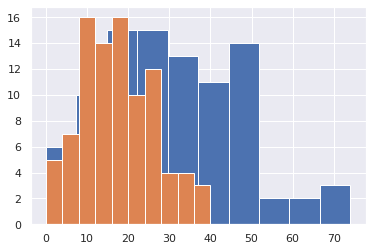

In [180]:
plt.hist(positive_daily_total)
plt.hist(negative_daily_total)

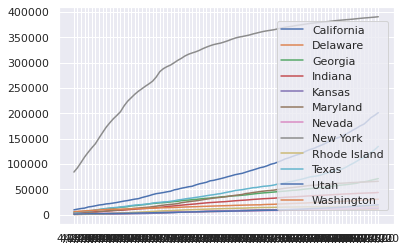

In [260]:
for state in target_users.values():
    plt.plot(US_df[state], label=state)
    plt.legend(loc='right')

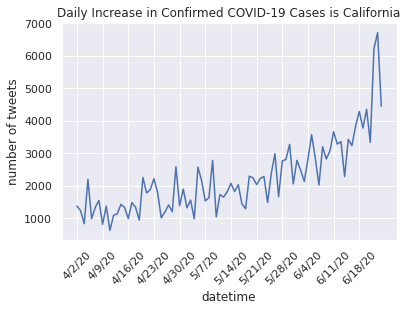

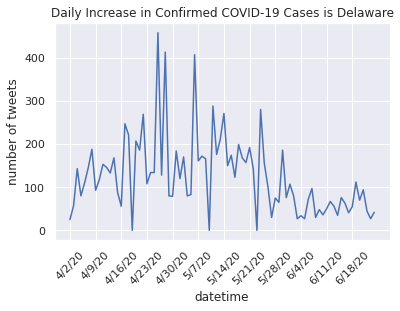

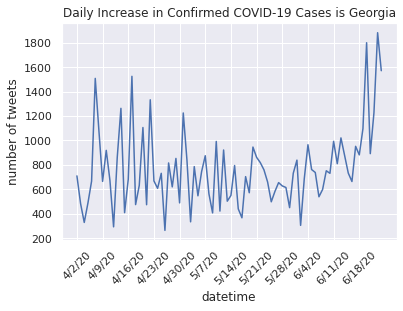

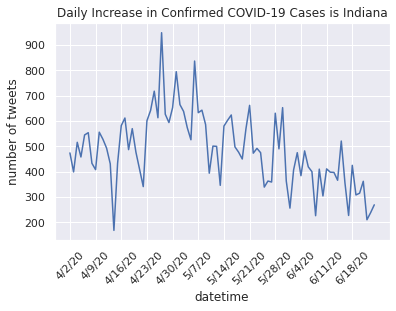

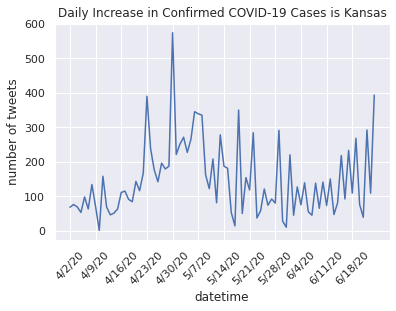

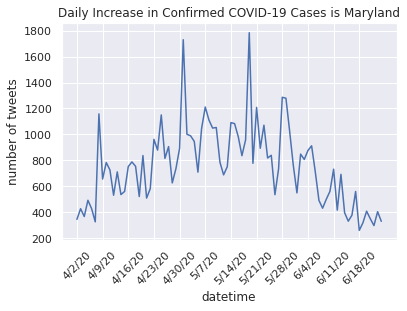

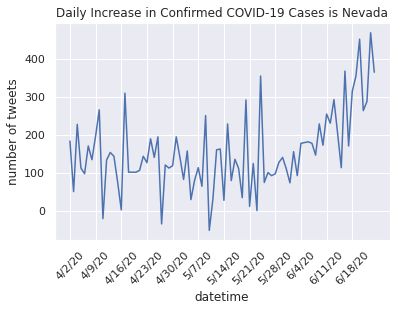

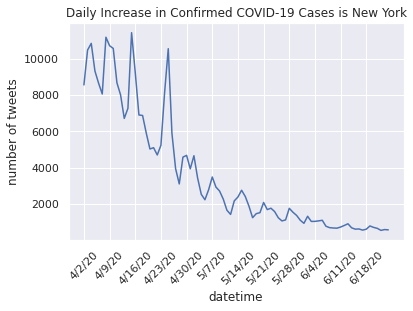

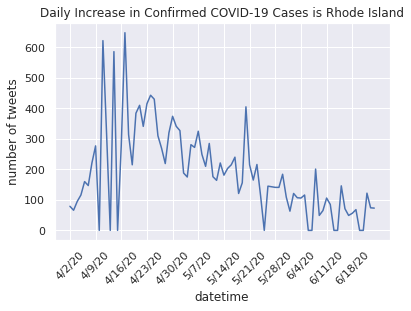

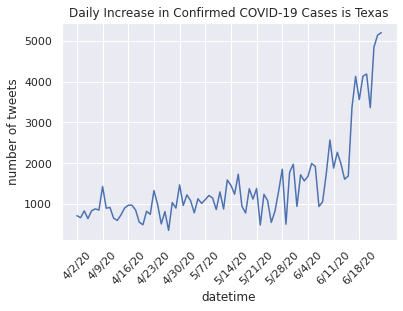

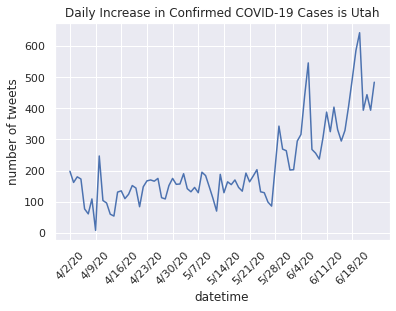

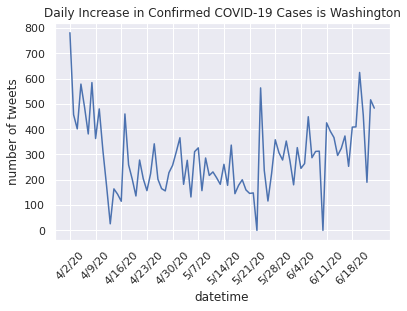

In [303]:
i = 0
for state in target_users.values():
    plt.figure(i)
    i += 1
    plt.title(f"Daily Increase in Confirmed COVID-19 Cases is {state}")
    plt.plot(increase_df[state], label=state)
    plt.xlabel('datetime')
    plt.ylabel('number of tweets')
    
    ticks = (increase_df[state].keys())[::7]  
    plt.xticks(ticks, rotation = 45)
    
    plt.savefig(f"graphs/{state}_daily_increase_cases.png")

From these plots, we can see that all the states seem to have a peak. However, this peak could have occured in April (New York, Rhode Island), May (Delaware, Indiana, Kansas, Maryland) or June (California, Georgia, Nevada, Texas).

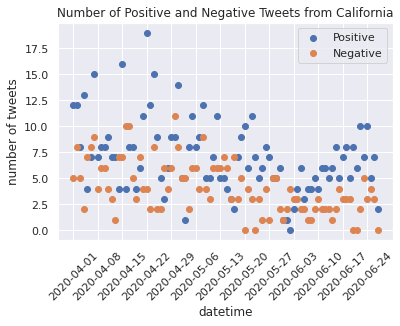

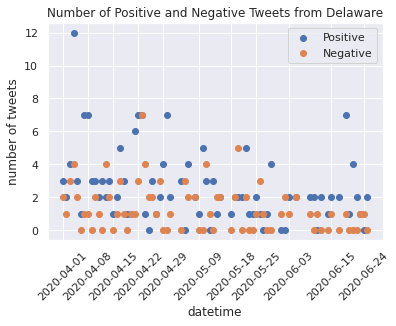

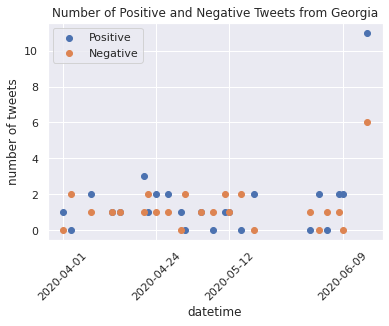

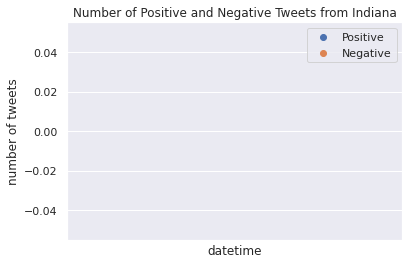

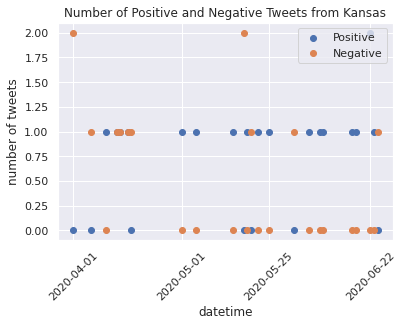

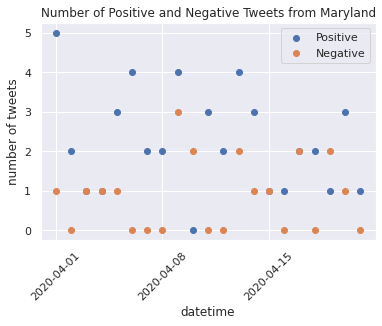

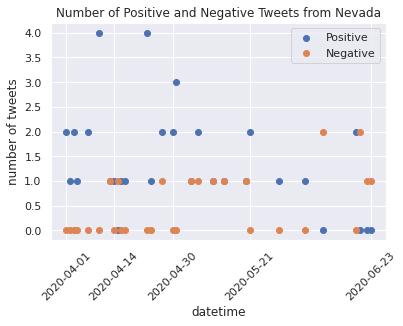

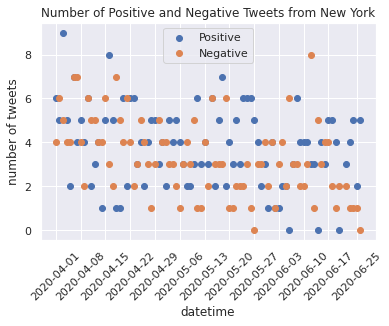

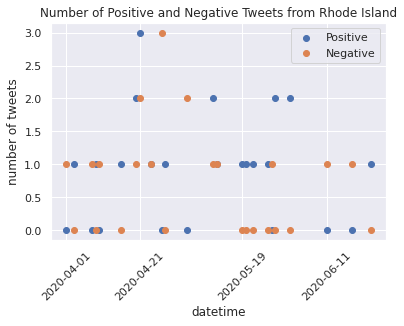

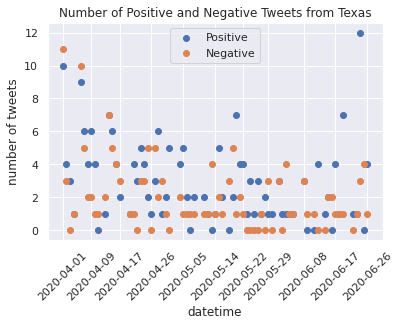

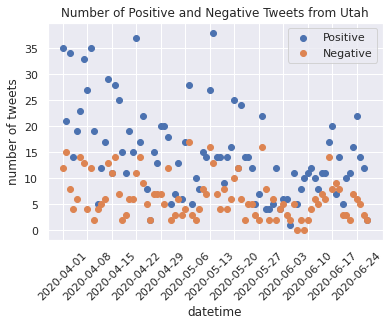

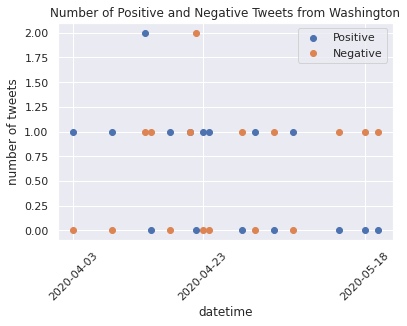

In [306]:
for t_user in target_users:
    u_pos = []
    u_neg = []
    dates = []
    for date in users_daily_sentiments_count:
        user_values = users_daily_sentiments_count[date][t_user]
        if len(user_values) > 0:
            u_pos.append(user_values[0])
            u_neg.append(user_values[1])
            dates.append(date)
            
    plt.figure(i)
    i += 1
    plt.scatter(dates, u_pos, label='Positive')
    plt.scatter(dates, u_neg, label='Negative')
    plt.legend()
    plt.title(f"Number of Positive and Negative Tweets from {target_users[t_user]}")
    plt.xlabel('datetime')
    plt.ylabel('number of tweets')
    
    ticks = dates[::7]  
    plt.xticks(ticks, rotation = 45)
    
    plt.savefig(f"graphs/{target_users[t_user]}_positive_negative_tweets.png")    

From the above grpahs, you can see that only Clalifornia, Delaware, New York and Utah are tweeting consistently and with high numbers.

In [308]:
datafull_states = ['California', 'Delaware', 'New York', 'Utah']

## Conclusion

After initial investigation, it appears that there doesn't seem to be any correlation between the number of positive, negative or total tweets from state-level government officals and the spread of COVID-19.

A few reasons why this might be the case are:
* The binary "Positive"/"Negative" classification was too simplistic to represent the affects of communication on the spread of the virus. A more suffisticated attempt could have included several different classifications: "Informative", "Questions", "Humorous", "Sarcastic" etc. Similarly, confidence weightings could have been applied to the predictions to get a better idea of how positive/negative tweets on a given day were.
* The number of followers that a user has does not equate to the engagment of those followers. It is possible that only a few people saw and took notice of the officials' tweets. This could have been controlled for using a measurment of influence such as the T-Index. Data could also have been collected from the general public to better reflect actual conversations (however, given the time and monetary constraints this was not feasable for this initial project).
* The effects of the tweets may have a delay of several days, or even weeks. For example, someone may see a tweet telling them to buy a mask, but not buy one for another few days. This could have been confounded further by the early asymptomatic nature of the virus. With more time and data, it would be possible to conducted lagged correlations to see if this is the case.

## Closing Remarks

I would like to thank you for taking the time to read this notebook. I found it to be a very fun problem, even though the outcome was not as impactful as I'd hoped... at least, for the time being.

I also learnt a couple of new skills throughout The Data Incubator Challenge, and also got a good chance to practice a few skills that I hadn't used for a while.

Thanks again!